In [14]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.sparse import csr_matrix, vstack

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [15]:
# Numeric data
num_dat = func.load_data_file('train_numeric')

y = num_dat['data']['y']
data = num_dat['data']['features']
ids = num_dat['data']['ids']
n_f_names = num_dat['data']['feature_names'][1:]

del num_dat

Returning <open file '/Volumes/My Book/kaggle_bosch/train_numeric.pkl', mode 'rb' at 0x12615b270>.pkl


In [16]:
# Load numeric data test
num_dat = func.load_data_file('test_numeric')
ids_test = num_dat['data']['ids']
data = vstack([data, num_dat['data']['features']], format='csr')
del num_dat

Returning <open file '/Volumes/My Book/kaggle_bosch/test_numeric.pkl', mode 'rb' at 0x12615b270>.pkl


In [17]:
ids_all = pd.concat([ids, ids_test], axis=0)

In [18]:
n_1 = y[y.Response==1].index.values
n_0 = y[y.Response==0].index.values

In [19]:
ids_test.head(3)

,Id
0,1
1,2
2,3


In [20]:
y = y.reindex(pd.concat([ids.Id, ids_test.Id]))

In [21]:
# Load look-up table
lut = pd.read_csv(const.LOOK_UP_TABLE)
lut.head(3)

,line,station,feature_nr,feat_nr_dat,name_dat,name_cat,name_num,col_dat,col_num,col_cat,station_V2,line_V2
0,0,0,0,1.0,L0_S0_D1,NaN,L0_S0_F0,0.0,0.0,NaN,0.0,1.0
1,0,0,2,3.0,L0_S0_D3,NaN,L0_S0_F2,1.0,1.0,NaN,0.0,1.0
2,0,0,4,5.0,L0_S0_D5,NaN,L0_S0_F4,2.0,2.0,NaN,0.0,1.0


In [22]:
# Read start time per station (discard features related to t delta)
t_station = pd.read_csv(os.path.join(const.DATA_PATH, 'feat_set_date_station.csv')).iloc[:,:129]
t_station.head(3)

,Id,t_0.0,t_1.0,t_2.0,t_3.0,t_4.0,t_5.0,t_6.0,t_7.0,t_8.0,...,t_42.0,t_43.0,t_44.0,t_45.0,t_46.0,t_47.0,t_48.0,t_49.0,t_50.0,t_51.0
0,4,8224.0,8224.0,8224.0,NaN,8226.0,NaN,NaN,8226.0,8227.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,161870.0,161870.0,161870.0,NaN,NaN,161872.0,161872.0,NaN,161873.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data.shape[0]

2367495

## Calculate lead/lag value per numeric feature

In [24]:
def calculate_lead_lag_numeric(ft_nr):

    # Get station number 
    station = lut[lut.feature_nr==ft_nr].station_V2.values[0]
    
    # Column nr in sparse array
    n_col = lut[lut.feature_nr==ft_nr].col_num.values[0]
    
    if not n_col>=0:
        return None
    
    # Samples with value for this feature
    i_n = data[:, n_col].nonzero()[0]
    
    # Timestamps for these values from station
    i_t = (~t_station.iloc[i_n, t_station.columns.get_loc('t_' + str(station))].isnull()).index.values

    # Samples with value and timestamp
    i = list(set(i_n) & set(i_t))
    
    # Get value, timestamp, and Response for each sample and combine in DataFrame
    v = data[i, n_col].todense().A1
    
    # Station timestamps were stored *100, so need to divide by 100 again
    t = 1.0/100*t_station.iloc[i, t_station.columns.get_loc('t_' + str(station))].values
    r = y.iloc[i]['Response'].values
    
    df = pd.DataFrame({'ID': ids_all.iloc[i].Id.values, 
                       't': t,
                       'v': v, 
                       'r':r})
    
    #df['t'] = df['t'].round(0)
    
    df.sort_values(['t','v','ID'], inplace=True)

    # Check nan in t (if large, adjust code for t)
    print('F nr: {} | Feature values: {} | Time values: {} | Nans found: {}'.format(ft_nr,
                                                                                    len(i_n),
                                                                                    len(i_t),
                                                                                    (np.isnan(t)).sum()))
    
    # Calculate lead and lag values...
    
    # Selected widths
    widths = [10, 20, 50, 100]
    
    # Use Pandas rolling windows to quickly generate lead and lag values
    # All are shifted by 1 to prevent that sample itself is included (leakage)
    for w in widths:
        df['next_{}_num_nan'.format(w)] = \
            df['r'][::-1].rolling(window=w, center=False, min_periods=1). \
                apply(lambda x: np.count_nonzero(np.isnan(x))).shift(1)
        df['next_{}_num_sum'.format(w)] = \
            df['r'][::-1].rolling(window=w, center=False, min_periods=1). \
                sum().shift(1)

        df['previous_{}_num_nan'.format(w)] = \
            df['r'].rolling(window=w, center=False, min_periods=1). \
                apply(lambda x: np.count_nonzero(np.isnan(x))).shift(1)
        df['previous_{}_num_sum'.format(w)] = \
            df['r'].rolling(window=w, center=False, min_periods=1). \
                sum().shift(1)
    
    # Group
    #df.groupby('r').filter.mean()
    
    return df

In [27]:
a = calculate_lead_lag_numeric(3857)

F nr: 3857 | Feature values: 2229189 | Time values: 2229189 | Nans found: 0


In [28]:
a=a[['ID','r','t','v']]
a.sort_values('ID', inplace=True)

a['t_prev'] = a['t'].shift(1)
a['t_next'] = a['t'].shift(-1)

a['r_prev'] = a['r'].shift(1)
a['r_next'] = a['r'].shift(-1)

a['v_prev'] = a['v'].shift(1)
a['v_next'] = a['v'].shift(-1)

In [59]:
a.sort_values(['t','v'], inplace=True)
a['ID_diff'] = a['ID'].diff()
a['ID_diff_rev'] = a['ID'][::-1].diff()
a.loc[a['ID_diff'].abs()>1, 'ID_diff'] = 9999
a.loc[a['ID_diff_rev'].abs()>1, 'ID_diff_rev'] = 9999
a['r_prev2'] = a['r'].shift(1)
a['r_next2'] = a['r'].shift(-1)

In [29]:
# GF0
a['gf0_t'] = -1 + \
                1 * ((a['t_prev']==a['t']) & (a['r_prev'].isnull())).astype(int) + \
                2 * ((a['t_prev']==a['t']) & (a['r_prev']==1)).astype(int)
        
# GF0
a['gf1_t'] = -1 + \
                1 * ((a['t_next']==a['t']) & (a['r_next'].isnull())).astype(int) + \
                2 * ((a['t_next']==a['t']) & (a['r_next']==1)).astype(int)
        
a['gf0_num'] = -1 + \
                1 * ((a['v_prev']==a['v']) & (a['r_prev'].isnull())).astype(int) + \
                2 * ((a['v_prev']==a['v']) & (a['r_prev']==1)).astype(int)
        
# GF0
a['gf1_num'] = -1 + \
                1 * ((a['v_next']==a['v']) & (a['r_next'].isnull())).astype(int) + \
                2 * ((a['v_next']==a['v']) & (a['r_next']==1)).astype(int)
        
a['gf0_num_t'] = -1 + \
                1 * ((a['t_prev']==a['t']) & (a['v_prev']==a['v']) & (a['r_prev'].isnull())).astype(int) + \
                2 * ((a['t_prev']==a['t']) & (a['v_prev']==a['v']) & (a['r_prev']==1)).astype(int)
        
# GF0
a['gf1_num_t'] = -1 + \
                1 * ((a['t_next']==a['t']) & (a['v_next']==a['v']) & (a['r_next'].isnull())).astype(int) + \
                2 * ((a['t_next']==a['t']) & (a['v_next']==a['v']) & (a['r_next']==1)).astype(int)

In [45]:
a[a['ID']==559839][['ID','r','r_prev2','r_next2','ID_diff']]

,ID,r,r_prev2,r_next2,ID_diff
263360,559839,0.0,1.0,NaN,1.0


In [51]:
(a[a['ID_diff']==1]['r_prev2'] - a[a['ID_diff']==1]['r']).value_counts()

 0.0    30787
 1.0     1763
-1.0       98
dtype: int64

In [60]:
res = a.groupby(['gf0_num', 'gf1_num','ID_diff','ID_diff_rev','r']).count().iloc[:,0].unstack('r')
res['ratio'] = res[1.0] / res[0.0] 
res

r                                         0.0     1.0     ratio
gf0_num gf1_num ID_diff ID_diff_rev                            
-1      -1      1.0     -1.0           3994.0    34.0  0.008513
                         9999.0       22399.0    19.0  0.000848
                9999.0  -1.0          22325.0  1487.0  0.066607
                         9999.0      997332.0  1432.0  0.001436
         0      1.0     -1.0           4106.0    42.0  0.010229
                         9999.0          37.0     NaN       NaN
                9999.0  -1.0          21979.0  1736.0  0.078984
                         9999.0        1463.0     1.0  0.000684
         1      1.0     -1.0             14.0     3.0  0.214286
                9999.0  -1.0             61.0   208.0  3.409836
                         9999.0           1.0     NaN       NaN
 0      -1      1.0     -1.0           4122.0   134.0  0.032508
                         9999.0       23808.0    49.0  0.002058
                9999.0  -1.0             35.0     2.0  0.057143
                         9999.0        1524.0     3.0  0.001969
         0      1.0     -1.0           4083.0   139.0  0.034044
                         9999.0          42.0     NaN       NaN
                9999.0  -1.0             31.0     1.0  0.032258
                         9999.0           2.0     NaN       NaN
         1      1.0     -1.0             23.0    19.0  0.826087
                         9999.0           1.0     NaN       NaN
 1      -1      1.0     -1.0             74.0   106.0  1.432432
                         9999.0        1623.0    20.0  0.012323
                9999.0   9999.0           3.0     NaN       NaN
         0      1.0     -1.0             64.0   104.0  1.625000
                         9999.0           2.0     NaN       NaN
         1      1.0     -1.0              NaN     7.0       NaN

In [58]:
res = a.groupby(['gf0_num', 'gf1_num','r']).count().iloc[:,0].unstack('r')
res['ratio'] = res[1.0] / res[0.0] 
res

r                      0.0     1.0     ratio
gf0_num gf1_num                             
-1      -1       1046051.0  2972.0  0.002841
         0         27585.0  1779.0  0.064492
         1            76.0   211.0  2.776316
 0      -1         29489.0   188.0  0.006375
         0          4158.0   140.0  0.033670
         1            24.0    19.0  0.791667
 1      -1          1700.0   126.0  0.074118
         0            66.0   104.0  1.575758
         1             NaN     7.0       NaN

In [53]:
a.head()

,ID,r,t,v,t_prev,t_next,r_prev,r_next,v_prev,v_next,gf0_t,gf1_t,gf0_num,gf1_num,gf0_num_t,gf1_num_t,ID_diff,r_prev2,r_next2
191443,407384,0.0,0.44,-0.032,584.88,974.93,NaN,0.0,0.006,0.133,-1,-1,-1,-1,-1,-1,NaN,NaN,NaN
1338803,476673,NaN,0.44,0.002,550.23,570.96,NaN,0.0,-0.015,-0.137,-1,-1,-1,-1,-1,-1,69289.0,0.0,0.0
185672,395059,0.0,0.44,0.018,1064.61,1325.88,0.0,0.0,0.196,-0.021,-1,-1,-1,-1,-1,-1,-81614.0,NaN,0.0
186881,397647,0.0,0.44,0.036,575.34,1105.37,NaN,0.0,-0.075,0.095,-1,-1,-1,-1,-1,-1,2588.0,0.0,NaN
1411922,631848,NaN,0.44,0.056,777.54,460.43,0.0,0.0,-0.009,0.018,-1,-1,-1,-1,-1,-1,234201.0,0.0,0.0


In [155]:
a[(a['gf1_num']==1) & (a['gf1_t']==0)]

,ID,r,t,v,t_prev,t_next,r_prev,r_next,v_prev,v_next,gf0_t,gf1_t,gf0_num,gf1_num,gf0_num_t,gf1_num_t


In [156]:
res = a.groupby(['gf0_t', 'gf1_t','r']).count().iloc[:,0].unstack('r')
res['ratio'] = res[1.0] / res[0.0] 
res

r                  0.0     1.0     ratio
gf0_t gf1_t                             
-1    -1     1052076.0  3356.0  0.003190
       0       26203.0  2117.0  0.080792
       1          75.0   296.0  3.946667
 0    -1       28469.0   240.0  0.008430
       0        4094.0   194.0  0.047386
       1          23.0    20.0  0.869565
 1    -1        2066.0   171.0  0.082769
       0          77.0   145.0  1.883117
       1           NaN     7.0       NaN

In [157]:
res = a.groupby(['gf0_num', 'gf1_num','r']).count().iloc[:,0].unstack('r')
res['ratio'] = res[1.0] / res[0.0] 
res

r                      0.0     1.0     ratio
gf0_num gf1_num                             
-1      -1       1035190.0  3312.0  0.003199
         0         34361.0  2114.0  0.061523
         1           113.0   295.0  2.610619
 0      -1         36706.0   263.0  0.007165
         0          4529.0   218.0  0.048134
         1            26.0    21.0  0.807692
 1      -1          2072.0   171.0  0.082529
         0            86.0   145.0  1.686047
         1             NaN     7.0       NaN

In [158]:
res = a.groupby(['gf0_num_t', 'gf1_num_t','r']).count().iloc[:,0].unstack('r')
res['ratio'] = res[1.0] / res[0.0] 
res

r                          0.0     1.0     ratio
gf0_num_t gf1_num_t                             
-1        -1         1052077.0  3356.0  0.003190
           0           26203.0  2117.0  0.080792
           1              75.0   296.0  3.946667
 0        -1           28468.0   240.0  0.008431
           0            4094.0   194.0  0.047386
           1              23.0    20.0  0.869565
 1        -1            2066.0   171.0  0.082769
           0              77.0   145.0  1.883117
           1               NaN     7.0       NaN

In [68]:
a[a['t']==836.9].groupby('v')['r'].agg(['count','sum','mean']).reset_index().sort_values('sum', ascending=False)

,v,count,sum,mean
0,-0.212,14,8.0,0.571429
4,0.013,8,1.0,0.125000
1,-0.156,5,0.0,0.000000
2,-0.099,15,0.0,0.000000
3,-0.043,15,0.0,0.000000
5,0.069,16,0.0,0.000000
6,0.125,12,0.0,0.000000
7,0.181,10,0.0,0.000000
8,0.238,7,0.0,0.000000


In [180]:
def max_min(x):
    return x.max()-x.min()

def any_larger_than_n(x, n=4):
    return (x>n).sum()>0

In [181]:
c = a.groupby(['t','v'])['r'].agg(['sum','mean']).reset_index().groupby('t')['sum','mean'].agg({'sum':['sum', any_larger_than_n], 'mean': [max_min]})

In [194]:
c.loc[375.0]

sum   sum                  25.000000
      any_larger_than_n     1.000000
mean  max_min               0.134524
Name: 375.0, dtype: float64

In [192]:
c.sort_values([('sum','sum')], ascending=False)

sum                        mean
         sum any_larger_than_n   max_min
t                                       
1374.0  37.0               1.0  0.036885
677.0   35.0               1.0  0.031646
374.0   28.0               1.0  0.023130
886.0   27.0               1.0  0.061720
375.0   25.0               1.0  0.134524
836.0   25.0               1.0  0.022693
838.0   25.0               1.0  0.020638
187.0   24.0               1.0  0.013255
825.0   24.0               1.0  0.018771
889.0   24.0               1.0  0.020906
819.0   23.0               1.0  0.028169
618.0   22.0               1.0  0.020619
204.0   22.0               1.0  0.019108
691.0   22.0               1.0  0.020151
371.0   22.0               1.0  0.013986
369.0   21.0               1.0  0.028571
259.0   21.0               1.0  0.026866
880.0   20.0               1.0  0.083333
352.0   20.0               1.0  0.028169
895.0   20.0               1.0  0.018116
1375.0  20.0               1.0  0.024450
619.0   20.0               1.0  0.033898
877.0   20.0               1.0  0.030718
186.0   19.0               1.0  0.014925
671.0   19.0               1.0  0.018904
325.0   18.0               1.0  0.022222
268.0   18.0               1.0  0.066667
1518.0  18.0               1.0  0.017612
1477.0  18.0               1.0  0.016506
609.0   18.0               1.0  0.017505
...      ...               ...       ...
1492.0   0.0               0.0  0.000000
1499.0   0.0               0.0  0.000000
1502.0   0.0               0.0  0.000000
1508.0   0.0               0.0  0.000000
1510.0   0.0               0.0  0.000000
1516.0   0.0               0.0  0.000000
1407.0   0.0               0.0  0.000000
1378.0   0.0               0.0  0.000000
1158.0   0.0               0.0  0.000000
1298.0   0.0               0.0  0.000000
1161.0   0.0               0.0  0.000000
1164.0   0.0               0.0  0.000000
1165.0   0.0               0.0  0.000000
1221.0   0.0               0.0  0.000000
1241.0   0.0               0.0  0.000000
1243.0   0.0               0.0  0.000000
1244.0   0.0               0.0  0.000000
1258.0   0.0               0.0  0.000000
1300.0   0.0               0.0  0.000000
1366.0   0.0               0.0  0.000000
1307.0   0.0               0.0  0.000000
1315.0   0.0               0.0  0.000000
1325.0   0.0               0.0  0.000000
1333.0   0.0               0.0  0.000000
1358.0   0.0               0.0  0.000000
1359.0   0.0               0.0  0.000000
1360.0   0.0               0.0  0.000000
1362.0   0.0               0.0  0.000000
1714.0   0.0               0.0  0.000000
901.0    NaN               0.0       NaN

[684 rows x 3 columns]

In [182]:
c[(c['sum']['any_larger_than_n']>0) & (c['mean']['max_min']>0.2)]

Empty DataFrame
Columns: [(sum, sum), (sum, any_larger_than_n), (mean, max_min)]
Index: []

In [195]:
a[a['t']==375.0].groupby('v')['r'].agg(['count','sum','mean']).reset_index().sort_values('sum', ascending=False)

,v,count,sum,mean
1,-0.216,299,6.0,0.020067
3,-0.179,568,6.0,0.010563
4,-0.161,262,6.0,0.022901
2,-0.197,415,5.0,0.012048
0,-0.234,120,1.0,0.008333
5,-0.143,7,1.0,0.142857


In [36]:
a.groupby(['t','v'])['r'].agg(['count','sum','mean']).reset_index().sort_values('sum', ascending=False)

,t,v,count,sum,mean
68137,1376.7,-0.156,32,9.0,0.281250
33738,738.7,-0.088,27,8.0,0.296296
39786,836.9,-0.212,14,8.0,0.571429
68140,1376.7,0.013,21,6.0,0.285714
68139,1376.7,-0.043,28,6.0,0.214286
64478,1297.6,0.125,35,6.0,0.171429
33737,738.7,-0.144,19,6.0,0.315789
68143,1376.7,0.181,23,6.0,0.260870
75659,1527.6,0.069,25,5.0,0.200000
21622,499.2,-0.032,23,5.0,0.217391


In [ ]:
a.groupby(['t','v'])['r'].agg(['count','sum','mean']).reset_index().sort_values('sum', ascending=False)

In [21]:
a.groupby('r').mean()

,ID,t,v,next_10_num_nan,next_10_num_sum,previous_10_num_nan,previous_10_num_sum,next_20_num_nan,next_20_num_sum,previous_20_num_nan,previous_20_num_sum,next_50_num_nan,next_50_num_sum,previous_50_num_nan,previous_50_num_sum,next_100_num_nan,next_100_num_sum,previous_100_num_nan,previous_100_num_sum
r,,,,,,,,,,,,,,,,,,,
0.0,1184946,850.422716,0.000007,4.993937,0.028442,4.993707,0.028676,9.997885,0.057390,9.997776,0.057498,24.997970,0.144020,24.997139,0.144873,49.996758,0.288558,49.995239,0.290212
1.0,1189117,765.193294,-0.011222,4.983792,0.140673,5.023089,0.140673,9.996028,0.227009,10.011305,0.227009,24.879927,0.485793,25.012832,0.485793,49.769478,0.882829,50.023220,0.882829


## Create gf0 / gf1 features based on numeric, t, numeric + t

In [204]:
#for f_nr in lut['feature_nr'].unique():
shortlist = ["L3_S33_F3857",   "L3_S32_F3850", 
"L3_S33_F3859",  "L3_S29_F3354","L3_S30_F3754", "L3_S30_F3759",  "L3_S30_F3749", "L3_S33_F3865", "L3_S30_F3804", 
"L3_S29_F3348", 
"L3_S29_F3351", "L3_S29_F3345",   "L3_S30_F3554",  
"L3_S29_F3321", "L3_S30_F3494", "L3_S29_F3342",   "L3_S29_F3373", 
"L3_S29_F3324",   "L3_S30_F3769", "L3_S29_F3427",  "L3_S30_F3829"]

for f_name in shortlist:
    # Read local error rate file for specific features
    # Extract single column
    # Add column to dataframe
    f_nr = lut[lut['name_num']==f_name].feature_nr.values[0]
    output = calculate_lead_lag_numeric(f_nr)
    
    if isinstance(output, pd.DataFrame):
    
        output = output[['ID','r','t','v']]
        output.sort_values('ID', inplace=True)

        output['t_prev'] = output['t'].shift(1)
        output['t_next'] = output['t'].shift(-1)

        output['r_prev'] = output['r'].shift(1)
        output['r_next'] = output['r'].shift(-1)

        output['v_prev'] = output['v'].shift(1)
        output['v_next'] = output['v'].shift(-1)
        
        # GF0
        output['gf0_t'] = -1 + \
                        1 * ((output['t_prev']==output['t']) & (output['r_prev'].isnull())).astype(int) + \
                        2 * ((output['t_prev']==output['t']) & (output['r_prev']==1)).astype(int)

        # GF0
        output['gf1_t'] = -1 + \
                        1 * ((output['t_next']==output['t']) & (output['r_next'].isnull())).astype(int) + \
                        2 * ((output['t_next']==output['t']) & (output['r_next']==1)).astype(int)

        output['gf0_num'] = -1 + \
                        1 * ((output['v_prev']==output['v']) & (output['r_prev'].isnull())).astype(int) + \
                        2 * ((output['v_prev']==output['v']) & (output['r_prev']==1)).astype(int)

        # GF0
        output['gf1_num'] = -1 + \
                        1 * ((output['v_next']==output['v']) & (output['r_next'].isnull())).astype(int) + \
                        2 * ((output['v_next']==output['v']) & (output['r_next']==1)).astype(int)

        output['gf0_num_t'] = -1 + \
                        1 * ((output['t_prev']==output['t']) & (output['v_prev']==output['v']) & (output['r_prev'].isnull())).astype(int) + \
                        2 * ((output['t_prev']==output['t']) & (output['v_prev']==output['v']) & (output['r_prev']==1)).astype(int)

        # GF0
        output['gf1_num_t'] = -1 + \
                        1 * ((output['t_next']==output['t']) & (output['v_next']==output['v']) & (output['r_next'].isnull())).astype(int) + \
                        2 * ((output['t_next']==output['t']) & (output['v_next']==output['v']) & (output['r_next']==1)).astype(int)
                
                
        output.set_index('ID', inplace=True)

        output.filter(like='gf').to_csv(os.path.join(const.BASE_PATH, 'feat_set_num_gf_feat_nr_{}.csv'.format(f_nr)), index_label='ID')
        #break
    else:
        print('No numeric data for feature {}'.format(f_nr))

F nr: 3857 | Feature values: 2229189 | Time values: 2229189 | Nans found: 0
F nr: 3850 | Feature values: 48678 | Time values: 48678 | Nans found: 0
F nr: 3859 | Feature values: 2229189 | Time values: 2229189 | Nans found: 0
F nr: 3354 | Feature values: 2239066 | Time values: 2239066 | Nans found: 0
F nr: 3754 | Feature values: 2238895 | Time values: 2238895 | Nans found: 17
F nr: 3759 | Feature values: 2238895 | Time values: 2238895 | Nans found: 17
F nr: 3749 | Feature values: 2238895 | Time values: 2238895 | Nans found: 17
F nr: 3865 | Feature values: 2229189 | Time values: 2229189 | Nans found: 0
F nr: 3804 | Feature values: 2239366 | Time values: 2239366 | Nans found: 17
F nr: 3348 | Feature values: 2239066 | Time values: 2239066 | Nans found: 0
F nr: 3351 | Feature values: 2239066 | Time values: 2239066 | Nans found: 0
F nr: 3345 | Feature values: 2239066 | Time values: 2239066 | Nans found: 0
F nr: 3554 | Feature values: 2238895 | Time values: 2238895 | Nans found: 17
F nr: 3321 

## View feature results

In [26]:
#for f_nr in lut['feature_nr'].unique():
shortlist = ["L3_S33_F3857",   "L3_S32_F3850", 
"L3_S33_F3859",  "L3_S29_F3354","L3_S30_F3754", "L3_S30_F3759",  "L3_S30_F3749", "L3_S33_F3865", "L3_S30_F3804", 
"L3_S29_F3348", 
"L3_S29_F3351", "L3_S29_F3345",   "L3_S30_F3554",  
"L3_S29_F3321", "L3_S30_F3494", "L3_S29_F3342",   "L3_S29_F3373", 
"L3_S29_F3324",   "L3_S30_F3769", "L3_S29_F3427",  "L3_S30_F3829"]

for f_name in shortlist:
    # Read local error rate file for specific features
    # Extract single column
    # Add column to dataframe
    f_nr = lut[lut['name_num']==f_name].feature_nr.values[0]
    output = calculate_lead_lag_numeric(f_nr)
    
    if isinstance(output, pd.DataFrame):
    
        print(output.groupby('r').mean().filter(like='_sum'))

        print('Value counts next 10')
        print(output['next_10_num_sum'].value_counts())

        print('Value counts next 100')
        print(output['next_100_num_sum'].value_counts())

        #output.to_csv(os.path.join(const.BASE_PATH, 'feat_set_next_previous_num_feat_nr_{}.csv'.format(f_nr)))
        output[['ID','r','t','v']].to_csv(os.path.join(const.BASE_PATH, 'feat_set_next_previous_num_feat_nr_{}.csv'.format(f_nr)), index=False)
    else:
        print('No numeric data for feature {}'.format(f_nr))

F nr: 3857 | Feature values: 2229189 | Time values: 2229189 | Nans found: 0
     next_10_num_sum  previous_10_num_sum  next_20_num_sum  \
r                                                            
0.0         0.024032             0.024111         0.048166   
1.0         0.206467             0.206392         0.364292   

     previous_20_num_sum  next_50_num_sum  previous_50_num_sum  \
r                                                                
0.0             0.048401         0.121569             0.121646   
1.0             0.364226         0.765236             0.765236   

     next_100_num_sum  previous_100_num_sum  
r                                            
0.0          0.243593              0.244388  
1.0          1.234043              1.234043  
Value counts next 10
0.0    2176437
1.0      46419
2.0       3523
3.0        486
4.0        101
5.0         19
6.0          4
7.0          2
Name: next_10_num_sum, dtype: int64
Value counts next 100
0.0     1847760
1.0      27

In [28]:
a.head()

,ID,r,t,v,next_10_num_nan,next_10_num_sum,previous_10_num_nan,previous_10_num_sum,next_20_num_nan,next_20_num_sum,previous_20_num_nan,previous_20_num_sum,next_50_num_nan,next_50_num_sum,previous_50_num_nan,previous_50_num_sum,next_100_num_nan,next_100_num_sum,previous_100_num_nan,previous_100_num_sum
1381888,555356,NaN,0.38,-0.200,6.0,0.0,NaN,NaN,12.0,0.0,NaN,NaN,25.0,1.0,NaN,NaN,53.0,1.0,NaN,NaN
1381889,555357,NaN,0.38,-0.200,5.0,0.0,NaN,NaN,11.0,0.0,NaN,NaN,24.0,1.0,NaN,NaN,52.0,1.0,NaN,NaN
2224302,2336275,NaN,0.38,-0.200,5.0,0.0,NaN,NaN,11.0,0.0,NaN,NaN,24.0,1.0,NaN,NaN,51.0,1.0,NaN,NaN
232262,492065,0.0,0.38,-0.144,6.0,0.0,NaN,NaN,12.0,0.0,NaN,NaN,25.0,1.0,NaN,NaN,51.0,1.0,NaN,NaN
194781,412433,0.0,0.38,-0.088,6.0,0.0,3.0,0.0,13.0,0.0,3.0,0.0,26.0,1.0,3.0,0.0,51.0,1.0,3.0,0.0


In [22]:
a.groupby('r').mean().filter(like='_sum')

,next_10_num_sum,previous_10_num_sum,next_20_num_sum,previous_20_num_sum,next_50_num_sum,previous_50_num_sum,next_100_num_sum,previous_100_num_sum
r,,,,,,,,
0.0,0.028142,0.028430,0.056917,0.056971,0.143177,0.143127,0.287189,0.288194
1.0,0.190032,0.190003,0.336847,0.336847,0.719829,0.719829,1.161473,1.161473


In [26]:
print('Value counts next 10')
print(a['next_10_num_sum'].value_counts())

Value counts next 10
0.0    2177306
1.0      54516
2.0       4438
3.0        549
4.0         81
5.0         13
6.0          3
7.0          2
Name: next_10_num_sum, dtype: int64


In [27]:
print('Value counts next 100')
print(a['next_100_num_sum'].value_counts())

Value counts next 100
0.0     1793242
1.0      318349
2.0       88332
3.0       23475
4.0        7731
5.0        2958
6.0        1650
7.0         995
8.0         707
9.0         379
10.0        307
11.0        160
12.0        121
14.0        109
13.0        104
15.0         73
17.0         72
18.0         62
16.0         57
20.0         36
19.0         28
22.0         28
23.0         23
24.0         23
25.0         20
21.0         20
26.0          3
Name: next_100_num_sum, dtype: int64


## Evaluate various features

In [41]:
cols = ['next_10_num_nan', 'next_10_num_sum', 'previous_10_num_nan', 'previous_10_num_sum',
 'next_20_num_nan', 'next_20_num_sum', 'previous_20_num_nan', 'previous_20_num_sum',
 'next_50_num_nan', 'next_50_num_sum', 'previous_50_num_nan', 'previous_50_num_sum',
 'next_100_num_nan', 'next_100_num_sum', 'previous_100_num_nan', 'previous_100_num_sum']

In [48]:
agg_0 = pd.DataFrame(index=lut['feature_nr'].unique(), columns = cols)
agg_1 = pd.DataFrame(index=lut['feature_nr'].unique(), columns = cols)

In [61]:
for f_nr in lut['feature_nr'].unique():
    print('Extracting {}'.format(f_nr))
    
    f_file = os.path.join(const.BASE_PATH, 
                          'feat_set_next_previous_num_feat_nr_{}.csv'.format(f_nr))
    
    if not os.path.exists(f_file):
        continue
                          
    output = pd.read_csv(f_file, index_col='ID')
    
    output = output.groupby('r')[cols].mean()
    
    agg_0.loc[f_nr] = output.loc[0.0]
    agg_1.loc[f_nr] = output.loc[1.0]

Extracting 0
Extracting 2
Extracting 4
Extracting 6
Extracting 8
Extracting 10
Extracting 12
Extracting 14
Extracting 16
Extracting 18
Extracting 20
Extracting 22
Extracting 24
Extracting 25
Extracting 27
Extracting 28
Extracting 29
Extracting 31
Extracting 32
Extracting 33
Extracting 35
Extracting 36
Extracting 37
Extracting 39
Extracting 40
Extracting 41
Extracting 43
Extracting 44
Extracting 45
Extracting 47
Extracting 48
Extracting 49
Extracting 51
Extracting 52
Extracting 53
Extracting 55
Extracting 56
Extracting 57
Extracting 59
Extracting 60
Extracting 61
Extracting 63
Extracting 64
Extracting 65
Extracting 67
Extracting 68
Extracting 69
Extracting 71
Extracting 72
Extracting 73
Extracting 75
Extracting 76
Extracting 77
Extracting 79
Extracting 80
Extracting 81
Extracting 83
Extracting 84
Extracting 85
Extracting 87
Extracting 88
Extracting 89
Extracting 91
Extracting 92
Extracting 93
Extracting 95
Extracting 96
Extracting 97
Extracting 99
Extracting 100
Extracting 101
Extractin

In [46]:
agg.loc[f_nr] = output.groupby('r')[cols].mean().loc[1.0]

In [62]:
agg_1.head()

,next_10_num_nan,next_10_num_sum,previous_10_num_nan,previous_10_num_sum,next_20_num_nan,next_20_num_sum,previous_20_num_nan,previous_20_num_sum,next_50_num_nan,next_50_num_sum,previous_50_num_nan,previous_50_num_sum,next_100_num_nan,next_100_num_sum,previous_100_num_nan,previous_100_num_sum
0,5.0336,0.156901,4.97031,0.15677,10.0685,0.258038,9.93376,0.258038,25.0003,0.525499,24.9839,0.525499,50.0119,0.852273,50.0502,0.852273
2,5.02746,0.150347,4.97338,0.150305,10.059,0.251386,10.0083,0.251386,24.9884,0.527439,24.9637,0.527439,49.9728,0.851441,50.0646,0.851441
4,4.93014,0.150263,5.03271,0.150263,9.95011,0.24612,10.0255,0.24612,25.0097,0.52439,25.0416,0.52439,49.9584,0.851718,50.0928,0.851718
6,5.00915,0.146105,4.98002,0.146267,9.9842,0.255266,10.0158,0.255266,25.0086,0.531596,25.0635,0.531596,49.9271,0.861419,50.0807,0.861419
8,5.0186,0.151582,4.97335,0.151582,10.0396,0.255266,9.99335,0.255266,24.9706,0.539911,25.0449,0.539911,49.8927,0.860865,50.0676,0.860865


In [63]:
agg_0.head()

,next_10_num_nan,next_10_num_sum,previous_10_num_nan,previous_10_num_sum,next_20_num_nan,next_20_num_sum,previous_20_num_nan,previous_20_num_sum,next_50_num_nan,next_50_num_sum,previous_50_num_nan,previous_50_num_sum,next_100_num_nan,next_100_num_sum,previous_100_num_nan,previous_100_num_sum
0,4.99807,0.0262271,4.99845,0.0258643,10.0058,0.052798,10.0066,0.0520729,25.0174,0.131834,25.0176,0.131746,50.0244,0.264294,50.0242,0.2645
2,4.99952,0.0262613,4.99984,0.0259626,10.0057,0.0524324,10.006,0.0521594,25.0155,0.131932,25.0157,0.131799,50.0249,0.264221,50.0245,0.264715
4,4.99865,0.0259489,4.99813,0.0265015,10.008,0.0523683,10.0077,0.0527741,25.0144,0.131529,25.0144,0.131701,50.0247,0.264067,50.0242,0.264791
6,4.99597,0.0262269,4.99614,0.0260998,10.0073,0.0523713,10.0071,0.0525414,25.0154,0.131373,25.0152,0.131668,50.0259,0.264081,50.0251,0.264907
8,4.99688,0.0262244,4.99714,0.0259809,10.0054,0.0524922,10.0057,0.052243,25.0167,0.131428,25.0163,0.131828,50.0233,0.264154,50.0223,0.265095


In [71]:
(agg_1 / agg_0).filter(like='_sum').mean()

next_10_num_sum         7.607240
previous_10_num_sum     8.261421
next_20_num_sum         5.647394
previous_20_num_sum     5.712329
next_50_num_sum         3.965427
previous_50_num_sum     3.987973
next_100_num_sum        2.954539
previous_100_num_sum    2.960948
dtype: float64

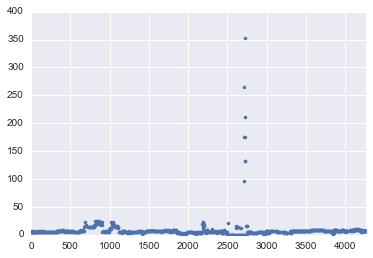

In [72]:
(agg_1 / agg_0)['previous_10_num_sum'].plot(linestyle='None', marker='.')

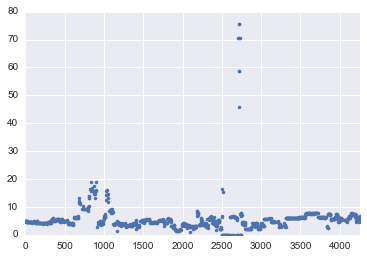

In [67]:
(agg_1 / agg_0)['previous_20_num_sum'].plot(linestyle='None', marker='.')

In [70]:
(agg_1 / agg_0).sort_values('previous_20_num_sum', ascending=False)

,next_10_num_nan,next_10_num_sum,previous_10_num_nan,previous_10_num_sum,next_20_num_nan,next_20_num_sum,previous_20_num_nan,previous_20_num_sum,next_50_num_nan,next_50_num_sum,previous_50_num_nan,previous_50_num_sum,next_100_num_nan,next_100_num_sum,previous_100_num_nan,previous_100_num_sum
2720,1.60182,75.5,0.501185,352.333,1.25172,50.3333,0.90402,75.5,1.12453,22.9783,1.06839,24.5814,1.08497,10.1635,0.962558,11.4891
2718,1.40345,81.3077,0.602222,211.4,1.25018,50.3333,0.902476,75.5,1.18755,21.14,0.989795,26.425,1.12424,9.69725,0.911155,12.0114
2712,1.30568,176.083,1.30568,176.083,1.20605,66.0625,1.15734,70.4667,1.04649,22.0208,1.02835,22.4894,1.11541,10.0667,0.951887,11.8764
2714,1.49674,88.0417,0.698941,264.125,1.19836,55.6316,1.00142,70.4667,1.08544,21.14,0.988397,23.4889,1.12508,10.3627,0.982653,12.0114
2726,1.09969,105.55,0.900427,131.938,1.20319,52.85,0.95379,70.4667,1.16756,20.3269,0.948235,25.7805,1.12527,9.9717,0.941562,12.0114
2722,1.29497,117.389,0.996886,176.083,1.05149,50.3333,0.903033,58.7222,1.12522,20.7255,0.967524,24.5814,1.07419,10.1635,0.962152,11.3656
2724,1.10313,132.062,1.10366,132.062,1.04841,66.0625,1.15136,58.7222,1.08625,22.9783,1.06996,23.4889,1.09543,10.3627,0.982954,11.6154
2716,0.806642,132.062,1.11051,96.0455,0.80407,75.5,1.25995,45.9565,0.884956,25.1667,1.15036,19.2182,1.0234,10.7857,1.02288,10.7857
902,0.934759,22.54,0.948526,22.2189,0.958585,19.1384,0.969639,18.9194,1.03525,10.3134,0.967014,11.0922,0.997996,5.44253,0.978364,5.55458
839,0.962693,23.806,0.957651,23.9464,0.969265,19.018,0.976333,18.8805,1.04694,10.4105,0.976518,11.2314,1.00379,5.42066,0.974184,5.58833


## Create features based on lag/lead features


In [25]:
# Create shortlist
cols = ['next_10_num_sum', 'next_20_num_sum', 'next_50_num_sum', 'next_100_num_sum']
shortlist = ["L3_S33_F3857",   "L3_S32_F3850", 
"L3_S33_F3859",  "L3_S29_F3354","L3_S30_F3754", "L3_S30_F3759",  "L3_S30_F3749", "L3_S33_F3865", "L3_S30_F3804", 
"L3_S29_F3348", 
"L3_S29_F3351", "L3_S29_F3345",   "L3_S30_F3554",  
"L3_S29_F3321", "L3_S30_F3494", "L3_S29_F3342",   "L3_S29_F3373", 
"L3_S29_F3324",   "L3_S30_F3769", "L3_S29_F3427",  "L3_S30_F3829"]

output10 = pd.DataFrame(index=ids_all.Id, columns = shortlist)
output20 = pd.DataFrame(index=ids_all.Id, columns = shortlist)
output50 = pd.DataFrame(index=ids_all.Id, columns = shortlist)
output100 = pd.DataFrame(index=ids_all.Id, columns = shortlist)

for f_name in shortlist:
    # Read local error rate file for specific features
    # Extract single column
    # Add column to dataframe
    f_nr = lut[lut['name_num']==f_name].feature_nr.values[0]
    print('Extracting {} (nr {})'.format(f_name, f_nr))
    #print f_nr
    f_file = os.path.join(const.BASE_PATH, 
                          'feat_set_next_previous_num_feat_nr_{}.csv'.format(f_nr))
    
    output_f = pd.read_csv(f_file, index_col='ID')
    
    output10[f_name] = output_f['next_10_num_sum']
    output20[f_name] = output_f['next_20_num_sum']
    output50[f_name] = output_f['next_50_num_sum']
    output100[f_name] = output_f['next_100_num_sum']    

Extracting L3_S33_F3857 (nr 3857)
Extracting L3_S32_F3850 (nr 3850)
Extracting L3_S33_F3859 (nr 3859)
Extracting L3_S29_F3354 (nr 3354)
Extracting L3_S30_F3754 (nr 3754)
Extracting L3_S30_F3759 (nr 3759)
Extracting L3_S30_F3749 (nr 3749)
Extracting L3_S33_F3865 (nr 3865)
Extracting L3_S30_F3804 (nr 3804)
Extracting L3_S29_F3348 (nr 3348)
Extracting L3_S29_F3351 (nr 3351)
Extracting L3_S29_F3345 (nr 3345)
Extracting L3_S30_F3554 (nr 3554)
Extracting L3_S29_F3321 (nr 3321)
Extracting L3_S30_F3494 (nr 3494)
Extracting L3_S29_F3342 (nr 3342)
Extracting L3_S29_F3373 (nr 3373)
Extracting L3_S29_F3324 (nr 3324)
Extracting L3_S30_F3769 (nr 3769)
Extracting L3_S29_F3427 (nr 3427)
Extracting L3_S30_F3829 (nr 3829)


In [26]:
output10.to_csv(os.path.join(const.DATA_PATH,'feat_set_next_previous_num_all_10.csv'), index_label='ID')
output20.to_csv(os.path.join(const.DATA_PATH,'feat_set_next_previous_num_all_20.csv'), index_label='ID')
output50.to_csv(os.path.join(const.DATA_PATH,'feat_set_next_previous_num_all_50.csv'), index_label='ID')
output100.to_csv(os.path.join(const.DATA_PATH,'feat_set_next_previous_num_all_100.csv'), index_label='ID')

In [92]:
output100.head()

NameError: name 'output100' is not defined

In [91]:
output10.shape

(2367495, 21)

In [88]:
output10['L3_S33_F3859'].value_counts()

0.0    2176266
1.0      46596
2.0       3510
3.0        425
4.0        108
5.0         15
6.0          8
7.0          2
Name: L3_S33_F3859, dtype: int64